In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import random
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               download=False,
                               transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                               

In [3]:
def gen_sec(x: torch.Tensor, n: int) -> list:
    # x now is a tensor
    secrets = []
    x_d = x.shape[0]
    len_sec = x_d // n
    for i in range(n):
        sec = torch.zeros_like(x)
        sec[len_sec * i: len_sec * (i + 1)] = x[len_sec * i: len_sec * (i + 1)]
        secrets.append(sec)
    # print(f"x_d is {x_d}")
    return secrets

x = torch.tensor(np.arange(32))
secrets = gen_sec(x, 8)
print(secrets)

[tensor([0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 13, 14, 15,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16, 17,
        18, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 20, 21, 22, 23,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 24, 25, 26, 27,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  

In [4]:
def collect_sec(secrets: list, k: int, valid=True) -> torch.Tensor:
    n = len(secrets)
    if valid:
        selected_idx = random.sample(range(n), k)
    else:
        selected_idx = random.sample(range(n), k - 1)  # any k - 1 secrets would not work
    collected = torch.zeros_like(secrets[0])
    for idx in selected_idx:
        collected += secrets[idx]
    return collected

print(collect_sec(secrets, 6, True))
print(collect_sec(secrets, 6, False))
    

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  0,  0,  0,  0,  0,  0,  0,  0, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  0,  0,  0,  0])


In [11]:
class Autoencoder(nn.Module):
    def __init__(self, n, k):
        super(Autoencoder, self).__init__()
        self.n = n
        self.k = k
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            # nn.ReLU(),
            # nn.Linear(n, k),
            # nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)  
        x = self.decoder(x)
        return x
    
    # def forward(self, x):
    #     x = self.encoder(x)  
    #     secrets = gen_sec(x, self.n)  # a pool with n secrets
        
    #     valid_x = collect_sec(secrets, self.k, True)
    #     invalid_x = collect_sec(secrets, self.k, False)
    #     valid_y = self.decoder(valid_x)
    #     invalid_y = self.decoder(invalid_x)
    #     return valid_y, invalid_y

In [13]:
n, k = 8, 6
model = Autoencoder(n, k).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 300
for epoch in range(epochs):
    for img, _ in train_loader:
        img = img.view(img.size(0), -1).to(device)
        # invalid_img = torch.zeros_like(img)
        # print(img.shape)
        output = model(img)
        loss = criterion(output, img) # + criterion(invalid_output, invalid_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/300], Loss: 0.9274


In [81]:
n, k = 32, 30
# model = AutoEncoder(n, k).to(device)
model = Autoencoder(n, k).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30
for epoch in range(epochs):
    for img, _ in train_loader:
        img = img.view(img.size(0), -1).to(device)
        invalid_img = torch.zeros_like(img)
        # print(img.shape)
        output, invalid_output = model(img)
        loss = criterion(output, img) + criterion(invalid_output, invalid_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/30], Loss: 0.9301
Epoch [2/30], Loss: 0.9234
Epoch [3/30], Loss: 0.9200
Epoch [4/30], Loss: 0.9132
Epoch [5/30], Loss: 0.9049
Epoch [6/30], Loss: 0.9042
Epoch [7/30], Loss: 0.9043
Epoch [8/30], Loss: 0.9089
Epoch [9/30], Loss: 0.9106
Epoch [10/30], Loss: 0.9011
Epoch [11/30], Loss: 0.9066
Epoch [12/30], Loss: 0.9090
Epoch [13/30], Loss: 0.8867
Epoch [14/30], Loss: 0.9208
Epoch [15/30], Loss: 0.8922
Epoch [16/30], Loss: 0.8839
Epoch [17/30], Loss: 0.8837
Epoch [18/30], Loss: 0.8973
Epoch [19/30], Loss: 0.8968
Epoch [20/30], Loss: 0.8885
Epoch [21/30], Loss: 0.8939
Epoch [22/30], Loss: 0.8891
Epoch [23/30], Loss: 0.8921
Epoch [24/30], Loss: 0.8844
Epoch [25/30], Loss: 0.8906
Epoch [26/30], Loss: 0.9048
Epoch [27/30], Loss: 0.9041
Epoch [28/30], Loss: 0.8986
Epoch [29/30], Loss: 0.8836
Epoch [30/30], Loss: 0.8859


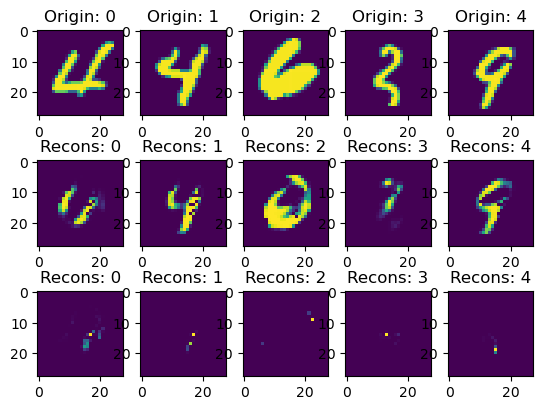

In [83]:
fig = plt.figure()

for i in range(5):
    idx = random.randint(0, len(test_dataset) - 1)
    img = test_dataset[idx][0][0]
    
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(f"Origin: {i}")

    plt.subplot(3, 5, i+6)
    with torch.no_grad():
        reconstructed, invalid_recons = model(img.view(-1, 784).to(device))
    plt.imshow(reconstructed.view(28, 28).to('cpu'))
    plt.title(f"Recons: {i}")

    plt.subplot(3, 5, i+11)
    plt.imshow(invalid_recons.view(28, 28).to('cpu'))
    plt.title(f"Recons: {i}")